In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CosineSimilarity

import pandas as pd
import numpy as np
import torchtext
import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from utils import train, compute_accuracy, plot_scores

seed = 265
torch.manual_seed(seed)

In [2]:
DEVICE = (
    torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))
print(f"On device {DEVICE}.")

On device cpu.


In [3]:
PATH_GENERATED_EMBS = 'generated/word_embeddings/'
PATH_GENERATED_TXT_GEN = 'generated/text_generation/'

CONTEXT_SIZE = 3

vocab = torch.load(PATH_GENERATED_EMBS + 'vocabulary.pt')
class_weights = torch.load(PATH_GENERATED_EMBS + 'class_weights.pt')
embedding = torch.load(PATH_GENERATED_EMBS + 'embedding.pt')

words_train = torch.load(PATH_GENERATED_EMBS + 'words_train.pt')
words_val = torch.load(PATH_GENERATED_EMBS + 'words_val.pt')
words_test = torch.load(PATH_GENERATED_EMBS + 'words_test.pt')

In [4]:
def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []

    for i in range(n_text - context_size):

        # Context before the target
        c = txt[i:i + context_size]

        # Word used to define target
        t = txt[i + context_size]
        
        targets.append(map_target[t])
        contexts.append(torch.tensor(c))
        
        
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

In [5]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED_TXT_GEN + fname):
        dataset = torch.load(PATH_GENERATED_TXT_GEN + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED_TXT_GEN + fname)
    return dataset

data_train = load_dataset(words_train, vocab, "data_train.pt")
data_val = load_dataset(words_val, vocab, "data_val.pt")
data_test = load_dataset(words_test, vocab, "data_test.pt")

In [6]:
class simple_RNN(nn.Module):
    
    def __init__(self, embedding=embedding, hidden_size = 32):
        super().__init__()
        
        (vocab_size, embedding_dim) = embedding.weight.shape
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False
        
        # RNN layer
        self.rnn1 = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

        # Regular MLP
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, vocab_size)

    def forward(self, x):
        
        out = self.embedding(x)

        out, _ = self.rnn1(out)
        # out is now of shape (N, context_size, embedding_dim)
        out = out[:, -1, :]
        
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*embedding_dim)
        
        out = self.fc2(out)
        return out

In [7]:
class medium_RNN(nn.Module):
    def __init__(self, embedding=embedding, hidden_size = 64):
        super().__init__()
        
        vocab_size, embedding_dim = embedding.weight.shape
         # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
         # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, vocab_size)

    def forward(self, out):
        out = self.embedding(out)
        out, _ = self.rnn(out)
        out = out[:, -1, :]
        out = F.gelu((self.fc1(out)))
        out = self.fc2(out)
        return out

In [8]:
class complex_RNN(nn.Module):
    def __init__(self, embedding=embedding, hidden_size = 128):
        super().__init__()
        
        vocab_size, embedding_dim = embedding.weight.shape
         # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
         # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, vocab_size)

    def forward(self, out):
        out = self.embedding(out)
        out, _ = self.rnn(out)
        out = out[:, -1, :]
        out = F.gelu(self.fc1(out))
        out = F.gelu(self.fc2(out))
        out = F.gelu(self.fc3(out))
        out = self.fc4(out)
        return out

In [9]:
torch.manual_seed(seed)

MODEL_FNAME = "txt_gen_model.pt"

batch_size=128
n_epochs=50

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)
class_weights = torch.load(PATH_GENERATED_EMBS + 'class_weights.pt').to(DEVICE)

simple = simple_RNN()
medium = medium_RNN()
complex = complex_RNN()

models = [complex, medium, simple]
stats = []

if os.path.isfile(PATH_GENERATED_TXT_GEN + MODEL_FNAME):
    # Load the trained model
    model = torch.load(PATH_GENERATED_TXT_GEN + MODEL_FNAME)
    model.to(DEVICE)
else:
    for model in models:
        # Or train the model...
        print(f'Trianing {model.__class__.__name__ }:')
        model.to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        loss_list, val_list = train(n_epochs, optimizer, model, train_loader, val_loader, loss_fn, device=DEVICE)

        acc = compute_accuracy(model, val_loader, device=DEVICE)
        stats.append((acc, val_list, loss_list))

        print()
        print(f'Validation accuracy: {acc}')
        print()
        print('------------------------------------------------------------------')
        print()

    # Pick best model based on validation accuracy
    best_model = models[stats.index(max(stats, key=lambda x: x[0]))]
    # Tuple containing val list and loss list
    best_model_stats = max(stats, key=lambda x: x[0])[1:]
    test_acc = compute_accuracy(best_model, test_loader, device=DEVICE)

    print(f'The best model was {best_model.__class__.__name__ }')
    print(f'Test accuracy of the best model: {test_acc}')

    # ... and save it
    torch.save(best_model.to(device="cpu"), PATH_GENERATED_TXT_GEN + MODEL_FNAME)
    torch.save(best_model_stats, PATH_GENERATED_TXT_GEN + 'best_model_stats.pt')

In [10]:
def test_model(model, data_test):
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)
    acc = compute_accuracy(model, test_loader, device=DEVICE)
    return acc*100
print("Accuracy of the best text_gen model on test set:")
print("=====================================================")
print(f"{round(test_model(model, data_test),4)}%")

Accuracy of the best text_gen model on test set:
1.6682%


## Beam search implementation

In [11]:
# Some helper functions

# Finds the k most probable words, given a context c
def find_next_words(c, k, model, probs=None, words=None):
        with torch.no_grad():
            temp_pred = model(c)
        softmax = torch.nn.Softmax(dim=1)

        temp_pred = softmax(temp_pred)
        probs, words = torch.topk(temp_pred, k=k, dim=1)

        return words, probs

# Returns the indexes of the k highest values in a list
def n_highest_index(l, k):
    indexed_list = list(enumerate(l))
    indexed_list.sort(key=lambda x: x[1], reverse=True)
    highest_indexes = [x[0] for x in indexed_list[:k]]
    return highest_indexes

def generate_scentences(c_list):
    responses = []
    for context in c_list:
        response_list = context
        word_list = vocab.lookup_tokens(response_list)

        response_scentence = ' '.join(word_list)

        responses.append(response_scentence)
    return responses

In [12]:
def beam_search(context, k, max_words, model):

    context_list = []
    prob_list = []
    # Creates a index map, that maps the best indexes in "temp_probs"
    # to their corresponding branch in context_list
    index_map = {i: i // k for i in range(k**2)}

    # We define context_list as a list with k lists, 
    # where each sub list represents a distinct branch
    if len(context[0]) == 1:
        for l in range(k):
            context_list.append([context.item()])

    else:                                                          
        for _ in range(k):
            context_list.append(context.squeeze(0).tolist())

    for i in range(max_words): 

        # Defining the base case, and the two next words if its a greedy search
        if i == 0 or k==1:
            first_words, _ = find_next_words(context, k, model)

        # If k==1, then we do a greedy search and ingore the rest of the loop
        if k==1:
            context = torch.concat((context, first_words), dim=1)

            context_l = context.tolist()
            response = generate_scentences(context_l)

            if i != max_words-1:
                continue
            else:
                return response
        
        # Store intermediate words for each step
        temp_words = []
        temp_probs = []
    
        # For each branch in the context list
        for j, context in enumerate(context_list):
            
            # Context is now the previous words for the current branch
            context = torch.tensor(context).unsqueeze(0)

            # Find the k next words
            new_words, new_probs = find_next_words(context, k, model)

            # Turn the new probabilities to logatithms
            new_probs = torch.log(new_probs)
   
            # If we have any stored probabilities then we find the probability of the 
            # exstenden branch my adding and the previous probabilities and normalize with length of current step
            if len(prob_list) != 0:
                for sub_prob in new_probs:
                    sub_prob += prob_list[j]
                    sub_prob *= (1/(i+1)**(0.75))   # We use aplha = 0.75 as suggested in lecture

            # We store the temporary probabilities as elements in 
            # a list (we take [0] instead of .sqeeze(0), and .item() to get the value)
            for idx in range(k):
                temp_words.append(new_words[0][idx].item())
                temp_probs.append(new_probs[0][idx].item())

            # For the first step, we create k temp probabiliteis, 
            # for all other steps we create k^2 temp probabilities
            if i == 0:
                break

        best_candidate_idx = n_highest_index(temp_probs, k)
        
        # We generate the base for a new context list
        base_context_list = [context_list[index_map[best_candidate_idx[x]]] for x in range(k)]

        # Then we make a list of the new words. The indices here should match the ones in base context list
        next_words = [temp_words[best_candidate_idx[x]] for x in range(k)]

        # We get our new context list by appending the new 
        # words to their corresponding branch in base context list
        context_list = [list(x) + [y] for x, y in zip(base_context_list, next_words)]
        
    responses = generate_scentences(context_list)

    most_prob_idx = n_highest_index(responses, 1)
    return responses, most_prob_idx[0]

In [26]:
prompt = 'Can'
tokenizer = get_tokenizer('basic_english')
model = torch.load(PATH_GENERATED_TXT_GEN + 'txt_gen_model.pt')

word_tensor = torch.tensor([vocab[w] for w in tokenizer(prompt)])
word_tensor = word_tensor.unsqueeze(0)

beam_width = 3
max_words = 2

if beam_width == 1:
    responses = beam_search(word_tensor, beam_width, max_words, model)
else:
    responses, most_prob_idx = beam_search(word_tensor, beam_width, max_words, model)
    print(f'Prompt: {prompt}')
    print()
    print(f'Responses with k = {beam_width} and sequence length = {max_words}:')
    print()
    for i, response in enumerate(responses):
        print(i+1, response)
    print()

if beam_width == 1:
    print(f'The most response width k==1 and sequence length = {max_words} was:')
    print(f'\033[92m{responses[0]}\033[0m') 
else:
    print('The most probable response was:')
    print(f'\033[92m{responses[most_prob_idx]}\033[0m') 

Prompt: Can

Responses with k = 3 and sequence length = 2:

1 can t hurt
2 can t hold
3 can be expected

The most probable response was:
can t hurt


## Visualization of Loss and Validation Performance

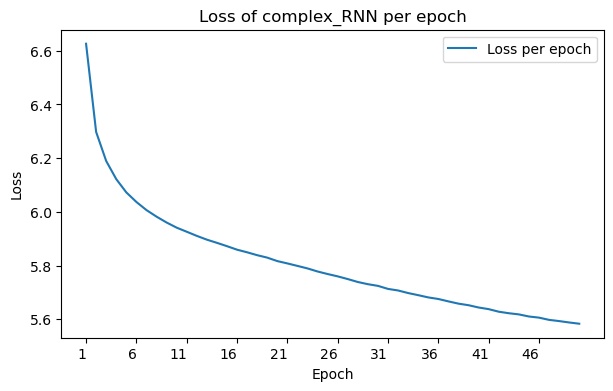

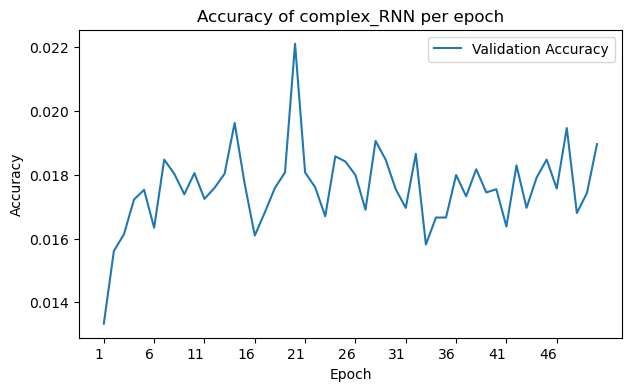

In [14]:
val_performance, losses = torch.load(PATH_GENERATED_TXT_GEN + 'best_model_stats.pt')
best_model = torch.load(PATH_GENERATED_TXT_GEN + MODEL_FNAME)

plot_scores(best_model, losses)
plot_scores(best_model, val_performance, loss=False)